In [1]:
import graphlab

A newer version of GraphLab Create (v1.8.5) is available! Your current version is v1.8.3.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.


In [2]:
loans = graphlab.SFrame('lending-club-data.gl/')

[INFO] GraphLab Create v1.8.3 started. Logging: C:\Users\ritraina\AppData\Local\Temp\graphlab_server_1460843077.log.0


In [3]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

In [4]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

Skipping observations with missing values

In [5]:
loans, loans_with_na = loans[[target] + features].dropna_split()

# Count the number of rows with missing data
num_rows_with_na = loans_with_na.num_rows()
num_rows = loans.num_rows()
print 'Dropping %s observations; keeping %s ' % (num_rows_with_na, num_rows)

Dropping 29 observations; keeping 122578 


Make sure the classes are balanced
We saw in an earlier assignment that this dataset is also imbalanced. 
We will undersample the larger class (safe loans) in order to balance out our dataset. 
We used seed=1 to make sure everyone gets the same results.

In [6]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502247166849
Percentage of risky loans                : 0.497752833151
Total number of loans in our new dataset : 46503


In [7]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many Kaggle competitions, 
and have been widely used in industry. We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

We will now train models to predict safe_loans using the features above. 
In this section, we will experiment with training an ensemble of 5 trees. 
To cap the ensemble classifier at 5 trees, we call the function with max_iterations=5 (recall that each iterations corresponds to adding a tree). 
We set validation_set=None to make sure everyone gets the same results.

In [8]:
model_5 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 5)

In [9]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float

Rows: 4

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     1      |   B   |      0.2      |     0     |       3        |    MORTGAGE    |
|     1      |   B   |      0.6      |     1     |       1        |      RENT      |
|     -1     |   D   |      0.4      |     0     |       3        |      RENT      |
|     -1     |   A   |      1.0      |     0     |       11       |    MORTGAGE    |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+--------------------+-------------------+-------------+------------------+
|  dti  |      purpose       | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+--------------------+-------------------+-------------+------------------+
| 29.44 |    credit_card     |      6.30496      |      0      |        1         |
| 12.19 |    credit_card     |      13.4952      |      0      |        1         |
| 13.97 |       other        |      2.96736      |      3      |        0         |
| 16.33 | debt_consolidation |      1.90524      |      0      |        1         |
+-------+--------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       0        |        1         |           1           |    8     |    0    |
|       0        |        1         |           1           |    8     |    0    |
|       0        |        0         |           1           |    14    |    0    |
|       0        |        1         |           1           |    17    |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    93.9    |        0.0         |   9.91   | ... |
|      1       |    59.1    |        0.0         |  11.71   | ... |
|      1       |    59.5    |        0.0         |  16.77   | ... |
|      1       |    62.1    |        0.0         |   8.9    | ... |
+--------------+------------+--------------------+----------+-----+
[4 rows x 25 columns]

Predicting on sample validation data
For each row in the sample_validation_data, write code to make model_5 predict whether or not the loan is classified as a safe loan.

In [127]:
correct_prediction = 0
acc = 0.0
for i in range(len(sample_validation_data)):
    prediction = model_5.predict(sample_validation_data[i])
  
    prediction_proba = model_5.predict(sample_validation_data[i], output_type='probability')
    print sample_validation_data[target][i], prediction

1 [1L]
1 [1L]
-1 [-1L]
-1 [1L]


In [27]:
model_5.evaluate(validation_data)

{'accuracy': 0.66813873330461,
 'auc': 0.7247215702188436,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      -1      |        1        |  1618 |
 |      -1      |        -1       |  3054 |
 |      1       |        -1       |  1463 |
 |      1       |        1        |  3149 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6715001599317625,
 'log_loss': 0.6176131784359803,
 'precision': 0.6605831760016782,
 'recall': 0.6827840416305291,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 4612 | 4672 |
 |   1e-05   | 1.0 | 1.0 | 4612 | 4672 |
 |   2e-05   | 1.0 | 

In [30]:
false_positive = 1618
false_negative = 1463
cost_of_mistakes = 1618*20000 + 1463*10000
print cost_of_mistakes

46990000


In [52]:
predictions = graphlab.SArray()
for i in range(len(validation_data)):
    predictions = model_5.predict(validation_data, output_type='probability')
validation_data.add_column(predictions, name='predictions')
print validation_data['predictions'] 

[0.4492515948736133, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325, 0.5947022876668167, 0.33775466395060033, 0.5894419838672718, 0.5446626343545116, 0.3429364757360745, 0.4100406423743146, 0.2832150471203802, 0.5691449603102926, 0.4696470182575727, 0.3429364757360745, 0.6144581479825972, 0.5540150331888919, 0.5142186875955691, 0.5819669503414138, 0.32206722185334985, 0.37709462571090163, 0.47570028819574917, 0.669717749870132, 0.5418839928263505, 0.5071180459249858, 0.4100406423743146, 0.5227286270781869, 0.17995233365429555, 0.5045105229286475, 0.5033908525310558, 0.47942587440211726, 0.41979291133183727, 0.5254866066815372, 0.5815758004350757, 0.4266440219499251, 0.6009397242320128, 0.45297345340355893, 0.5968388314127835, 0.4079179607389766, 0.7120326855781626, 0.49635122232102674, 0.4210338743757608, 0.5146543571899348, 0.4462275523101078, 0.779737882198072, 0.4468776559886932, 0.2069128670547538, 0.6439365814628348, 0.47608426994769015, 0.5635070599993113, 0.740563683

In [60]:
print "Your loans      : %s\n" % validation_data['predictions'].head(4)
print "Expected answer : %s" % [0.4492515948736132, 0.6119100103640573,
                                0.3835981314851436, 0.3693306705994325]

Your loans      : [0.4492515948736133, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]

Expected answer : [0.4492515948736132, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]


In [65]:
validation_data.sort('predictions', ascending=False)

safe_loans,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,payment_inc_ratio
1,A,0.2,0,11,MORTGAGE,4.21,credit_card,0.955726
1,A,0.4,0,4,MORTGAGE,12.76,car,1.7376
1,A,0.6,0,11,MORTGAGE,2.4,car,2.49545
1,A,0.2,0,11,MORTGAGE,6.47,major_purchase,1.131
1,A,0.2,0,11,OWN,0.69,car,3.17372
1,A,0.6,0,5,MORTGAGE,5.2,major_purchase,0.74268
1,A,0.4,0,11,MORTGAGE,10.95,credit_card,3.02852
1,A,0.2,0,11,OWN,8.92,home_improvement,2.44751
1,A,0.2,0,6,MORTGAGE,10.29,home_improvement,3.22264
1,A,0.2,0,11,MORTGAGE,6.1,major_purchase,2.30678


In [66]:
validation_data_safe_loans = validation_data[validation_data['predictions'] >= 0.5]
validation_data_safe_loans.sort('predictions', ascending=True)

safe_loans,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose
-1,C,0.4,0,3,MORTGAGE,6.61,small_business
-1,D,1.0,0,11,RENT,18.13,small_business
1,C,0.8,0,3,RENT,22.18,debt_consolidation
-1,D,0.4,0,3,MORTGAGE,20.35,debt_consolidation
1,D,0.2,0,5,RENT,21.01,credit_card
-1,D,0.2,0,11,MORTGAGE,30.21,debt_consolidation
-1,D,1.0,0,8,MORTGAGE,19.94,credit_card
-1,D,0.2,0,2,MORTGAGE,27.24,debt_consolidation
1,C,0.8,0,11,MORTGAGE,19.51,credit_card
-1,D,0.8,0,6,RENT,24.52,debt_consolidation


In [67]:
model_10 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 10, verbose=False)
model_50 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 50, verbose=False)
model_100 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 100, verbose=False)
model_200 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 200, verbose=False)
model_500 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 500, verbose=False)

In [69]:
train_err_10 = model_10.evaluate(train_data)['accuracy']
train_err_50 = model_50.evaluate(train_data)['accuracy']
train_err_100 = model_100.evaluate(train_data)['accuracy']
train_err_200 = model_200.evaluate(train_data)['accuracy']
train_err_500  = model_500.evaluate(train_data)['accuracy']

In [70]:
training_errors = [train_err_10, train_err_50, train_err_100, 
                   train_err_200, train_err_500]

In [76]:
validation_err_10 = model_10.evaluate(validation_data)['accuracy']
validation_err_50 =  model_50.evaluate(validation_data)['accuracy']
validation_err_100 = model_100.evaluate(validation_data)['accuracy']
validation_err_200 =  model_200.evaluate(validation_data)['accuracy']
validation_err_500 =  model_500.evaluate(validation_data)['accuracy']

In [77]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, 
                     validation_err_200, validation_err_500]
print validation_errors

[0.6727703576044808, 0.6910814304179234, 0.6917277035760449, 0.684510986643688, 0.6713700990952176]


In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

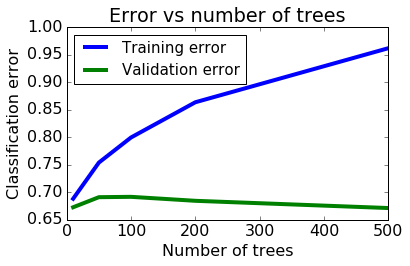

In [75]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')